## Food2Fork API ##
www.food2fork.com/about/api

In [2]:
# API access
import requests
import urllib2
from urllib import urlencode
import json
from bs4 import BeautifulSoup

# Plotting
from matplotlib import pyplot as plt

# Parsing ingredient lists
import re
import nltk
from fractions import Fraction
from ingredient_parser import parse # https://pypi.python.org/pypi/ingredient-parser/1.0.1

In [3]:
%matplotlib inline

### API credentials ###

In [4]:
def loadCredentials():
    filename = 'secrets.txt'
    for line in open(filename).readlines():
        if "API" in line:    
            api_key = line.split(": ")[1].translate(None,'\n')
        
    return api_key

In [5]:
# Load the API Key
_API_KEY = loadCredentials()

# Food2Fork links
_URL_API = "http://food2fork.com/api/"
_URL_SEARCH = _URL_API + 'search?'
_URL_GET    = _URL_API + 'get?'
_HEADER = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64)'}

### Search the Food2Fork API ###

In [6]:
def search(query, page=1, count=1):   
    """Return a list of recipes from the Food2Fork.com database"""
    
    assert(0 < count <= 30), 'max 30 results per call, min 1' #https://github.com/davebshow/food2forkclient/
        
    # Format the request URL
    query_params = {"key":_API_KEY,"q":query, "page":page, "count":count}            
    api_request = _URL_SEARCH + urlencode(query_params)    

    # Make the request
    request  = urllib2.Request(api_request, headers=_HEADER)
    response = urllib2.urlopen(request)
    raw = response.read()
    json_obj = json.loads(raw)['recipes']
    
    if len(json_obj)==1:    
        return json_obj[0]
    else:
        return json_obj

In [7]:
# Search for cookie recipes
recipes = search('Chocolate chip cookies',count=5)
print(recipes[0]['image_url'])
recipes[0]

http://static.food2fork.com/508714d505.jpg


{u'f2f_url': u'http://food2fork.com/view/6868',
 u'image_url': u'http://static.food2fork.com/508714d505.jpg',
 u'publisher': u'All Recipes',
 u'publisher_url': u'http://allrecipes.com',
 u'recipe_id': u'6868',
 u'social_rank': 99.99999999999996,
 u'source_url': u'http://allrecipes.com/Recipe/Chewy-Chocolate-Chip-Oatmeal-Cookies/Detail.aspx',
 u'title': u'Chewy Chocolate Chip Oatmeal Cookies'}

### Request a specific recipe from the API ###

In [8]:
def getRecipe(recipe_id):
    """Return the recipe specified by *recipe_id* from Food2Fork's database"""

    # Format the request URL
    api_request = _URL_GET + urlencode({"key":_API_KEY, "rId":recipe_id})
    
    # Make the request
    request  = urllib2.Request(api_request, headers=_HEADER)
    response = urllib2.urlopen(request)
    raw = response.read()
    json_obj = json.loads(raw)  
    
    return json_obj['recipe']

### Scrape ingredients from a Food2Fork.com page ###

In [9]:
def getIngredients(json_obj):
    r = getRecipe(json_obj['recipe_id'])
    return [i.strip('\n').encode('ascii', 'ignore').lower() for i in r['ingredients']]

## Parse ingredient amounts using reg exp and NLTK ##

#### Attempt to parse with regular expressions ####

In [10]:
class Ingredient(object):
    
    def __init__(self, name, amount='', units='', description=''):
        self._name = name # e.g. butter, sugar, etc. (this needs a better variable name than "name")        
        self._amount = amount # How many of units?
        self._units = units   # Measurement units (e.g. cup, tablespoon, pound, etc.)
        self._description = description # e.g. softened, blackened, etc.
                
    @property
    def name(self): # e.g. butter, chocolate chips, ground beef
        return self._name

    @property
    def units(self): # e.g. cups, teaspoons, oz
        return self._units
    
    @property
    def amount(self): # e.g. 1, 2, 1 1/2, 3/4
        return self._amount    
    
    @property
    def description(self): # e.g. softened, lightly-packed
        return self._description
    
    def __repr__(self):        
        return repr((self.amount, self.units, self.name))

In [11]:
# num_words = ['zero','one','two','three','four','five','six','seven','eight','nine',
#            'ten','eleven','twelve','thirteen','fourteen','fifteen','sixteen',
#            'seventeen','eighteen','nineteen','twenty']
# NUMBERS = dict(zip(num_words,range(0,len(num_words))))

In [12]:
def parseIngredients(ingredients):
    p = [parse(ingrd) for ingrd in ingredients]
    num_ingredients = len(p)

    # Use RegEx to get ingredient amount from parsed list
    expr = r'\d*\s*\d*((/|.)\d+)?'
    matches = [re.search(expr,ingrd['measure']) for ingrd in p]
    amounts = [match.group().strip() for match in matches]

    # Convert amounts to float
    amounts = [float(sum(Fraction(s) for s in a.split())) for a in amounts]

    # Get measurement unit from the RegEx matches
    units = [i['measure'][m.end():].strip() for i,m in zip(p,matches)]

    # Get parts of speech using NLTK
    pos = [nltk.pos_tag(nltk.word_tokenize(ingrd['name'])) for ingrd in p]

    # Ingredient names
    tags = ['NN','NNS','VBG'] #JJ also?
    names = [' '.join([part[0] for part in parts if part[1] in tags]) for parts in pos]

    # Ingredient descriptions
    tags = ['JJ','VBD']
    descriptions = [' '.join([part[0] for part in parts if part[1] in tags]) for parts in pos]
                    
    return [Ingredient(n,a,u,d) for a,u,n,d in zip(amounts,units,names,descriptions)]

In [13]:
search_result = search("Chocolate chip cookies",count=5)

In [14]:
ingredients = getIngredients(getRecipe(search_result[0]['recipe_id']))
ingredients

['1 cup butter, softened',
 '1 cup packed light brown sugar',
 '1/2 cup white sugar',
 '2 eggs',
 '2 teaspoons vanilla extract',
 '1 1/4 cups all-purpose flour',
 '1/2 teaspoon baking soda',
 '1 teaspoon salt',
 '3 cups quick-cooking oats',
 '1 cup chopped walnuts',
 '1 cup semisweet chocolate chips']

In [15]:
parsed = parseIngredients(ingredients)
parsed

[(1.0, 'cup', 'butter'),
 (1.0, 'cup', 'brown sugar'),
 (0.5, 'cup', 'sugar'),
 (2.0, '', 'eggs'),
 (2.0, 'teaspoon', 'vanilla extract'),
 (1.25, 'cup', 'flour'),
 (0.5, 'teaspoon', 'baking soda'),
 (1.0, 'teaspoon', 'salt'),
 (3.0, 'cup', 'oats'),
 (1.0, 'cup', 'walnuts'),
 (1.0, 'cup', 'semisweet chocolate chips')]

In [16]:
recipe = dict(zip([p.name for p in parsed],[p.amount for p in parsed]))
recipe

{'baking soda': 0.5,
 'brown sugar': 1.0,
 'butter': 1.0,
 'eggs': 2.0,
 'flour': 1.25,
 'oats': 3.0,
 'salt': 1.0,
 'semisweet chocolate chips': 1.0,
 'sugar': 0.5,
 'vanilla extract': 2.0,
 'walnuts': 1.0}

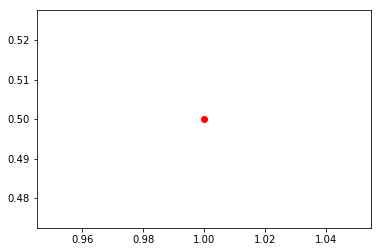

In [17]:
plt.plot(recipe['butter'],recipe['sugar'],'ro')
plt.show()

In [18]:
search_result = search("soup",count=5)

In [19]:
ingredients = getIngredients(getRecipe(search_result[0]['recipe_id']))
ingredients

['1 pound shredded, cooked chicken',
 '1 (15 ounce) can whole peeled tomatoes, mashed',
 '1 (10 ounce) can enchilada sauce',
 '1 medium onion, chopped',
 '1 (4 ounce) can chopped green chile peppers',
 '2 cloves garlic, minced',
 '2 cups water',
 '1 (14.5 ounce) can chicken broth',
 '1 teaspoon cumin',
 '1 teaspoon chili powder',
 '1 teaspoon salt',
 '1/4 teaspoon black pepper',
 '1 bay leaf',
 '1 (10 ounce) package frozen corn',
 '1 tablespoon chopped cilantro',
 '7 corn tortillas',
 'vegetable oil']